In [1]:
import os
import pickle

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

from scipy.sparse import csr_matrix, coo_matrix, hstack

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import roc_auc_score

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from tqdm import tqdm_notebook

from operator import itemgetter

import warnings
warnings.filterwarnings('ignore')

Считаем данные соревнования в DataFrame train_df и test_df (обучающая и тестовая выборки)


### **Считаем данные [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) в DataFrame train_df и test_df (обучающая и тестовая выборки)**

**Описание данных**

В обучающей выборке train_sessions.csv признаки site_i – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем site_dic.pkl).
Признаки time_j – время посещения сайтов site_j.

Целевой признак target – факт того, что сессия принадлжит Элис (то есть что именно Элис ходила по всем этим сайтам).

Задача – сделать прогнозы для сессий в тестовой выборке (test_sessions.csv), определить, принадлежат ли они Элис.

Не обязательно ограничиваться только предложенной выборкой train_sessions.csv – в train.zip даны исходные данные о посещенных пользователями веб-страницах, по которым можно сформировать свою обучающую выборку.

Train set train_sessions.csv contains information on user browsing sessions where the features are:

site_i – are ids of sites in this session. The mapping is given with a pickled dictionary site_dic.pkl.

time_j – are timestamps of attending the corresponding site.

target – whether this session belongs to Alice.

One can use original data train.zip to form a train set differing from train_sessions.csv.

In [2]:
PATH_TO_DATA = ('C:\\Users\pekach\\final\capstone_user_identification')

In [3]:
time = ['time1', 'time2', 'time3', 'time4', 'time5',
             'time6', 'time7', 'time8', 'time9', 'time10']

In [4]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id',parse_dates=time)
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id',parse_dates=time)

In [5]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,3846.0,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,39.0,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,782.0,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,178.0,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [35]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


### Первичный анализ данных

Посмотрим, что нам покажут распределения годов, месяцев, дней недели

In [6]:
train_time = train_df.copy()
test_time = test_df.copy()
train_time['year'] = train_df['time1'].apply(lambda x: x.year)
test_time['year'] = test_df['time1'].apply(lambda x: x.year)

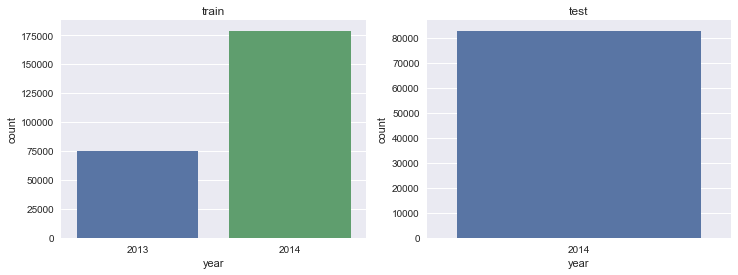

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(train_time['year'], ax=ax1)
ax1.set_title('train')
sns.countplot(test_time['year'], ax=ax2)
ax2.set_title('test');

Распределение месяцев трейн/тест

In [8]:
train_time['month'] = train_time['time1'].apply(lambda x: x.month)
test_time['month'] = test_time['time1'].apply(lambda x: x.month)

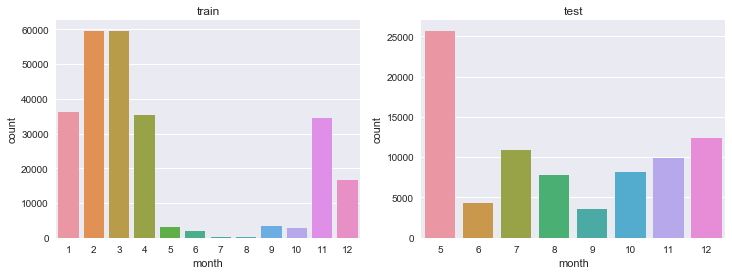

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(train_time['month'], ax=ax1)
ax1.set_title('train')
sns.countplot(test_time['month'], ax=ax2)
ax2.set_title('test');

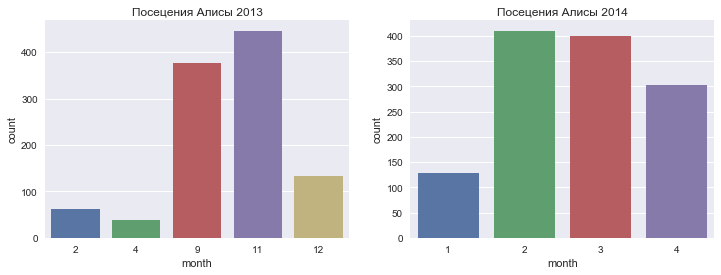

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(train_time['month'][train_time['year'] == 2013][train_time['target'] == 1], ax=ax1)
ax1.set_title(u'Посецения Алисы 2013')
sns.countplot(train_time['month'][train_time['year'] == 2014][train_time['target'] == 1], ax=ax2)
ax2.set_title(u'Посецения Алисы 2014');

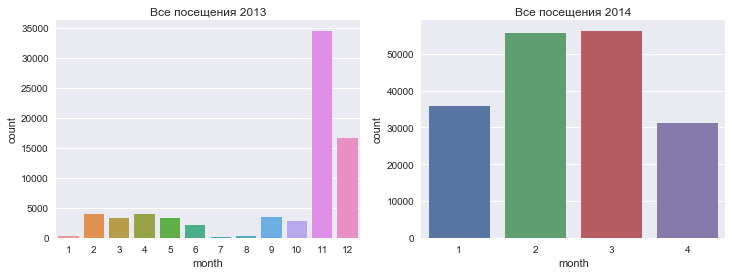

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(train_time['month'][train_time['year'] == 2013], ax=ax1)
ax1.set_title(u'Все посещения 2013')
sns.countplot(train_time['month'][train_time['year'] == 2014], ax=ax2)
ax2.set_title(u'Все посещения 2014');

**Объединим обучающую и тестовую выборки – это понадобится, чтобы вместе потом привести их к разреженному формату.**

In [12]:
train_test_df = pd.concat([train_df, test_df])

В обучающей выборке видим следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - user_id – ID пользователя
    
Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут. 

**Посмотрим на статистику признаков.**

Пропуски возникают там, где сессии короткие (менее 10 сайтов). Скажем, если человек 1 января 2015 года посетил *vk.com* в 20:01, потом *yandex.ru* в 20:29, затем *google.com* в 20:33, то первая его сессия будет состоять только из двух сайтов (site1 – ID сайта *vk.com*, time1 – 2015-01-01 20:01:00, site2 – ID сайта  *yandex.ru*, time2 – 2015-01-01 20:29:00, остальные признаки – NaN), а начиная с *google.com* пойдет новая сессия, потому что уже прошло более 30 минут с момента посещения *vk.com*.

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
site1     253561 non-null int64
time1     253561 non-null datetime64[ns]
site2     250098 non-null float64
time2     250098 non-null datetime64[ns]
site3     246919 non-null float64
time3     246919 non-null datetime64[ns]
site4     244321 non-null float64
time4     244321 non-null datetime64[ns]
site5     241829 non-null float64
time5     241829 non-null datetime64[ns]
site6     239495 non-null float64
time6     239495 non-null datetime64[ns]
site7     237297 non-null float64
time7     237297 non-null datetime64[ns]
site8     235224 non-null float64
time8     235224 non-null datetime64[ns]
site9     233084 non-null float64
time9     233084 non-null datetime64[ns]
site10    231052 non-null float64
time10    231052 non-null datetime64[ns]
target    253561 non-null int64
dtypes: datetime64[ns](10), float64(9), int64(2)
memory usage: 42.6 MB


In [14]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
site1     82797 non-null int64
time1     82797 non-null datetime64[ns]
site2     81308 non-null float64
time2     81308 non-null datetime64[ns]
site3     80075 non-null float64
time3     80075 non-null datetime64[ns]
site4     79182 non-null float64
time4     79182 non-null datetime64[ns]
site5     78341 non-null float64
time5     78341 non-null datetime64[ns]
site6     77566 non-null float64
time6     77566 non-null datetime64[ns]
site7     76840 non-null float64
time7     76840 non-null datetime64[ns]
site8     76151 non-null float64
time8     76151 non-null datetime64[ns]
site9     75484 non-null float64
time9     75484 non-null datetime64[ns]
site10    74806 non-null float64
time10    74806 non-null datetime64[ns]
dtypes: datetime64[ns](10), float64(9), int64(1)
memory usage: 13.3 MB


**В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно.**

In [15]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

**Пока для прогноза будем использовать только индексы посещенных сайтов. Индексы нумеровались с 1, так что заменим пропуски на нули.**

In [16]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [17]:
train_test_df_sites.head(10)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178
6,570,21,570,21,21,0,0,0,0,0
7,803,23,5956,17513,37,21,803,17514,17514,17514
8,22,21,29,5041,14422,23,21,5041,14421,14421
9,668,940,942,941,941,942,940,23,21,22


### **Создадим разреженные матрицы *X_train_sparse* и *X_test_sparse*. Сначала создадим объединенную матрицу *train_test_df_sites*, потом разделим обратно на обучающую и тестовую части.**

В сессиях меньше 10 сайтов у нас остались нули, так что первый признак (сколько раз попался 0) по смыслу отличен от остальных (сколько раз попался сайт с индексом $i$). Поэтому первый столбец разреженной матрицы надо удалить.

**Выделим в отдельный вектор *y* ответы на обучающей выборке.**

In [18]:
def csr(d, session):
    X_flt = d.flatten()
    matr = csr_matrix(([1]*X_flt.shape[0], X_flt, range(0, X_flt.shape[0] + session, session)))[:, 1:]
    return (matr)

In [19]:
train_test_sparse = csr(train_test_df_sites.values, 10)
X_train_sparse = train_test_sparse[:len(train_df)]
X_test_sparse = csr(test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int').values, 10)
y = train_df['target']

In [21]:
print(X_train_sparse.shape[0], X_train_sparse.shape[1], X_test_sparse.shape[0], X_test_sparse.shape[1])

(253561, 48371, 82797, 48371)


**Разобьем обучающую выборку на 2 части в пропорции 7/3, причем не перемешивая. Исходные данные упорядочены по времени, тестовая выборка по времени четко отделена от обучающей, это же соблюдем и здесь.**

In [22]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

### Обучение бейзлайна с помощью SGDClassifier и logit

In [23]:
%%time
sgd_logit = SGDClassifier(loss= "log",random_state=17,n_jobs=-1)
sgd_logit.fit(X_train, y_train)

Wall time: 322 ms


In [64]:
%%time
logit = LogisticRegression(random_state=42, n_jobs=-1)
logit.fit(X_train, y_train)

Wall time: 5.07 s


**Сделаем прогноз в виде предсказанных вероятностей того, что это сессия Элис, на отложенной выборке *(X_valid, y_valid)* и посчитаем roc-auc.**

In [24]:
sgd_logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)

roc_auc_sgd_logit = roc_auc_score(y_valid, sgd_logit_valid_pred_proba[:, 1])
print('ROC AUC score: {:.5f}'.format(roc_auc_sgd_logit))

ROC AUC score: 0.93385


In [66]:
logit_valid_pred_proba = logit.predict_proba(X_valid)

roc_auc_logit = roc_auc_score(y_valid, logit_valid_pred_proba[:, 1])
print('ROC AUC score: {:.5f}'.format(roc_auc_logit))

ROC AUC score: 0.95831


**Сделаем прогноз в виде предсказанных вероятностей отнесения к классу 1 для тестовой выборки с помощью той же *sgd_logit*, обученной уже на всей обучающей выборке (а не на 70%).**

In [68]:
%%time
sgd_logit.fit(X_train_sparse, y)
sgd_logit_test_pred_proba = sgd_logit.predict_proba(X_test_sparse)

Wall time: 440 ms


In [69]:
%%time
logit.fit(X_train_sparse, y)
logit_test_pred_proba = logit.predict_proba(X_test_sparse)

Wall time: 7.95 s


### Запись файла с ответами

In [25]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [71]:
write_to_submission_file(logit_test_pred_proba[:, 1], './logRes1.csv')

### Создадим новые фичи

**Создадим словарь с частотами посещения сайтов.**

In [76]:
def prepare_dictionary(ddf, session_length=10):
    files = ddf
    dic = {}
    counter = 0
    sessDic = {}
    session_length = 10
    df = pd.DataFrame()
    reList = list()
    site_counter=0
    for ind, dfile in enumerate(files):
        for sess in dfile:
            inner = 1
            if sess in dic:
                value = dic[sess]
                dic[sess] = (value[0],value[1]+1)
            if sess not in dic:
                counter += 1
                dic[sess] = (counter, inner)  
    if 0 in dic:
        del dic[0]
    return dic

In [79]:
site_freq_dict = prepare_dictionary(train_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int').values)

In [81]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_dict_alice.pkl'), 'wb') as site_freq_alice_pkl:
    pickle.dump(site_freq_dict, site_freq_alice_pkl, protocol=2)

** Разобьем DataFrame на сайты и время. Т.е. снаала в df поместим сайты, потом время**

In [26]:
%%time
site_cols = ['site%d' % i for i in range(1, 11)]
time_cols = ['time%d' % i for i in range(1, 11)]

train_test_df_st = train_test_df[site_cols + time_cols].copy()
train_test_df_st[site_cols] = train_test_df[site_cols].fillna(0).astype(int)

Wall time: 217 ms


In [27]:
train_test_df_st.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0,2014-02-20 10:02:45,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,890,941,3847,941,942,3846,3847,3846,1516,1518,2014-02-22 11:19:50,2014-02-22 11:19:50,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:52,2014-02-22 11:19:52,2014-02-22 11:20:15,2014-02-22 11:20:16
3,14769,39,14768,14769,37,39,14768,14768,14768,14768,2013-12-16 16:40:17,2013-12-16 16:40:18,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:20,2013-12-16 16:40:21,2013-12-16 16:40:22,2013-12-16 16:40:24
4,782,782,782,782,782,782,782,782,782,782,2014-03-28 10:52:12,2014-03-28 10:52:42,2014-03-28 10:53:12,2014-03-28 10:53:42,2014-03-28 10:54:12,2014-03-28 10:54:42,2014-03-28 10:55:12,2014-03-28 10:55:42,2014-03-28 10:56:12,2014-03-28 10:56:42
5,22,177,175,178,177,178,175,177,177,178,2014-02-28 10:53:05,2014-02-28 10:55:22,2014-02-28 10:55:22,2014-02-28 10:55:23,2014-02-28 10:55:23,2014-02-28 10:55:59,2014-02-28 10:55:59,2014-02-28 10:55:59,2014-02-28 10:57:06,2014-02-28 10:57:11


** Создадим новые признаки**

In [391]:
import itertools
from collections import Counter

В нивые признаки мы включим:

    уникальные сайты за сессию
    час начала сессии
    день недели
    проведенное время на каждом сайте
    месяц начала сессии
    день начала сессии

In [28]:
def prepare_train_set_with_fe(new_df):
    proc_df = pd.DataFrame(new_df, index=new_df.index)
    session_window = 10 
    sessDic ={} 
    df = pd.DataFrame()
    reList = list()
    site_counter=1
    
    site_cols = ['site%d' % i for i in range(1, 11)]
    time_cols = ['time%d' % i for i in range(1, 11)]
    
    site_list = proc_df[site_cols].values.tolist()
    time_diff = np.zeros( (proc_df.shape[0], (session_window - 1)), dtype=int)
    
    for inx, (num, time) in enumerate(proc_df[time_cols].iterrows(),0):
        
        
        
        site = site_list[inx]
        uninque = [x for x in site if x != 0]

        sessDic['#unique_sites'] = len(set(uninque))
        sessDic['start_hour'] = time.min().hour
        sessDic['day_of_week'] = time.min().dayofweek 
        sessDic['month'] = time.min().month 
        sessDic['day'] = time.min().day 
        
        for j in range(session_window - 1):
                if not pd.isnull(time[j]) and not pd.isnull(time[j + 1]):
                    #print ((time[j + 1] - time[j])/ np.timedelta64(1, 's') , j+1, inx)
                    sessDic['time_diff{i}'.format(i=j+1)] = int((time[j + 1] - time[j])/ np.timedelta64(1, 's'))
                else:
                    sessDic['time_diff{i}'.format(i=j+1)] = int(0)
                    break
        reList.append(sessDic)
        sessDic ={} 
        
    df = pd.DataFrame(reList)
    df = df.fillna(0).astype('int')
    df.index += 1 
    df
    return df

In [420]:
%%time
train_test_df_fe = prepare_train_set_with_fe(train_test_df_st)

Wall time: 7min 6s


In [136]:
train_test_df_fe.head()

,#unique_sites,day,day_of_week,month,start_hour,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9
1,1,20,3,2,10,0,0,0,0,0,0,0,0,0
2,7,22,5,2,11,0,1,0,0,0,1,0,23,1
3,4,16,0,12,16,1,1,0,0,0,1,1,1,2
4,1,28,4,3,10,30,30,30,30,30,30,30,30,30
5,4,28,4,2,10,137,0,1,0,36,0,0,67,5


In [422]:
with open(os.path.join(PATH_TO_DATA, 'new_feat.pkl'), 'wb') as new_feat_pkl:
    pickle.dump(train_test_df_fe, new_feat_pkl, protocol=2)

In [135]:
with open(os.path.join(PATH_TO_DATA, 'new_feat.pkl'), 'rb') as new_feat_pkl:
    train_test_df_fe = pickle.load(new_feat_pkl)

**Обучение модели с использованием новых признаков**

In [137]:
X_train_features = train_test_df_fe[:train_df.shape[0]]
X_test_features = train_test_df_fe[train_df.shape[0]:]

In [138]:
X_train_sparse_fe = hstack([X_train_sparse, X_train_features]).tocsr()
X_test_sparse_fe = hstack([X_test_sparse, X_test_features]).tocsr()
#готовые данные для обучения

In [123]:
X_train_sparse_fe.shape, X_test_sparse_fe.shape

((253561, 48385), (82797, 48385))

In [411]:
from sklearn.grid_search import GridSearchCV

In [139]:
%%time
train_share = int(.7 * X_train_sparse_fe.shape[0])
X_train, y_train = X_train_sparse_fe[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse_fe[train_share:, :], y[train_share:]

Wall time: 81 ms


In [46]:
logreg = LogisticRegression(random_state=17, n_jobs=-1)
logreg.fit(X_train, y_train)
logreg_preds_proba_up = logreg.predict_proba(X_valid)
score = roc_auc_score(y_valid, logreg_preds_proba_up[:, 1])
print('LogisticRegression (predict_proba): ', round(score, 3))

('LogisticRegression (predict_proba): ', 0.89)


Видим, что качество ухудшилось по сравенению с обычной моделью. Нарисуем кривую валидации, чтобы понять, что произошло

In [47]:
from sklearn.model_selection import learning_curve, validation_curve

def plot_learning_curve(estimator, title, X, y,label_y, ylim=None, cv=None, scoring='roc_auc', 
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(label_y)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [48]:
cv_iterator = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

Wall time: 3min 31s


<module 'matplotlib.pyplot' from 'C:\Users\pekach\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

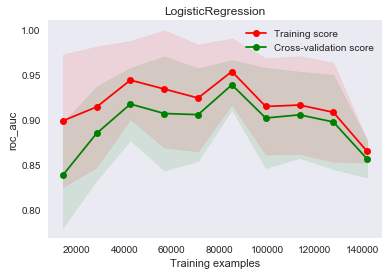

In [49]:
%%time
plot_learning_curve(logreg, 'LogisticRegression',
                    X_train, y_train, scoring='roc_auc', cv=cv_iterator, n_jobs=-1, label_y='roc_auc')

Проявляется переобучение – AUC падает как на обучении, так и на валидации. Увеличим коэффициент регуляризации

In [140]:
log = LogisticRegression(random_state=17, n_jobs=-1, C=2)
log.fit(X_train, y_train)
logreg_preds_proba_up = log.predict_proba(X_valid)
score = roc_auc_score(y_valid, logreg_preds_proba_up[:, 1])
print('LogisticRegression (predict_proba): ', round(score, 3))

('LogisticRegression (predict_proba): ', 0.973)


Wall time: 3min 18s


<module 'matplotlib.pyplot' from 'C:\Users\pekach\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

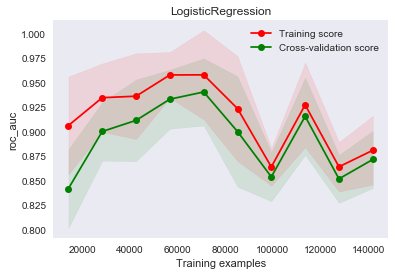

In [126]:
%%time
plot_learning_curve(log, 'LogisticRegression',
                    X_train, y_train, scoring='roc_auc', cv=cv_iterator, n_jobs=-1, label_y='roc_auc')

In [127]:
time_diff_cols = ['time_diff1', 'time_diff2', 'time_diff3', 'time_diff4', 'time_diff5',
                  'time_diff6', 'time_diff7', 'time_diff8', 'time_diff9']
train_test_df_fe.drop(time_diff_cols, axis=1,inplace=True)

In [128]:
X_train_features = train_test_df_fe[:train_df.shape[0]]
X_test_features = train_test_df_fe[train_df.shape[0]:]
X_train_sparse_fe = hstack([X_train_sparse, X_train_features]).tocsr()
X_test_sparse_fe = hstack([X_test_sparse, X_test_features]).tocsr()
#готовые данные для обучения
train_share = int(.7 * X_train_sparse_fe.shape[0])
X_train, y_train = X_train_sparse_fe[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse_fe[train_share:, :], y[train_share:]

In [130]:
log_reg = LogisticRegression(random_state=17, n_jobs=-1, C=2)
log_reg.fit(X_train, y_train)
logreg_preds_proba_up = log_reg.predict_proba(X_valid)
score = roc_auc_score(y_valid, logreg_preds_proba_up[:, 1])
print('LogisticRegression (predict_proba): ', round(score, 3))

('LogisticRegression (predict_proba): ', 0.973)


Wall time: 1min 35s


<module 'matplotlib.pyplot' from 'C:\Users\pekach\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

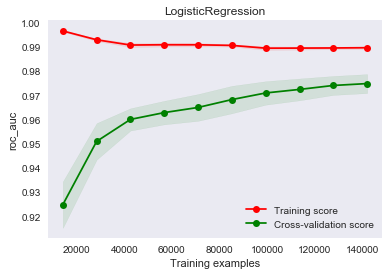

In [131]:
%%time
plot_learning_curve(log_reg, 'LogisticRegression',
                    X_train, y_train, scoring='roc_auc', cv=cv_iterator, n_jobs=-1, label_y='roc_auc')

Видим хорошую тенденцию – кривые постепенно сходятся, и если дальше двигаться направо (добавлять в модель данные), можно еще повысить качество на валидации.

Сохраним модель и отправим на kaggle

In [109]:
logit = LogisticRegression(C=2, random_state=17, max_iter=100)

logit.fit(X_train_sparse_fe, y)
logit_test_pred_proba = logit.predict_proba(X_test_sparse_fe)

In [110]:
write_to_submission_file(logit_test_pred_proba[:, 1], './res_logit.csv')

### Оценка модели
Удалось получить модель, которая хорошо предсказывает взломщика на фоне других пользователей.
### Выводы
Полученную модель можно с использовать для идентификации нетипичного поведения и обнаружения взломщиков.